## Analysis of model coefficients

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
results_dir = '/home/jake/data/pancancer_vogelstein_09_25'
pancancer_dir = os.path.join(results_dir, 'pancancer')
single_cancer_dir = os.path.join(results_dir, 'single_cancer')

In [3]:
sample_info_df = du.load_sample_info()
tcga_cancer_types = list(np.unique(sample_info_df.cancer_type))

identifier_coefs_info = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        cancer_covs = au.get_cancer_type_covariates(coefs, tcga_cancer_types)
        identifier_coefs_info.append((identifier, fold_no, len(cancer_covs), cancer_covs))
        
# TODO: do we need a way to generate list of all features?
ids_df = pd.DataFrame(identifier_coefs_info, columns=['identifier', 'fold', 'nz_cov_count', 'nz_covs'])
ids_df[ids_df.nz_cov_count > 0].head(n=10)

,identifier,fold,nz_cov_count,nz_covs
12,MLH1_UCEC,0,1,[UCEC]
14,MLH1_UCEC,2,1,[UCEC]
196,BRCA1_BLCA,0,1,[UCEC]
197,BRCA1_BLCA,1,1,[UCEC]
245,CBL_UCEC,1,1,[UCEC]
246,CBL_UCEC,2,1,[UCEC]
247,CBL_UCEC,3,1,[UCEC]
268,GNA11_UVM,0,1,[UVM]
295,MAP2K1_SKCM,3,1,[SKCM]
304,MET_LUAD,0,1,[UCEC]


In [4]:
# load significant identifiers and join into coefficients dataframe
pancancer_comparison_df = pd.read_csv(os.path.join(results_dir, 'pancancer_pvals.tsv'),
                                      index_col=False, sep='\t')
merge_df = (
    ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
          .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
merge_df.head(n=8)

,identifier,fold,nz_cov_count,nz_covs,reject_null
0,MAP3K1_BRCA,0,0,[],True
1,MAP3K1_BRCA,1,0,[],True
2,MAP3K1_BRCA,2,0,[],True
3,MAP3K1_BRCA,3,0,[],True
4,MAP3K1_COAD,0,0,[],False
5,MAP3K1_COAD,1,0,[],False
6,MAP3K1_COAD,2,0,[],False
7,MAP3K1_COAD,3,0,[],False


Text(0, 0.5, 'Number of models (fold/cancer type/gene)')

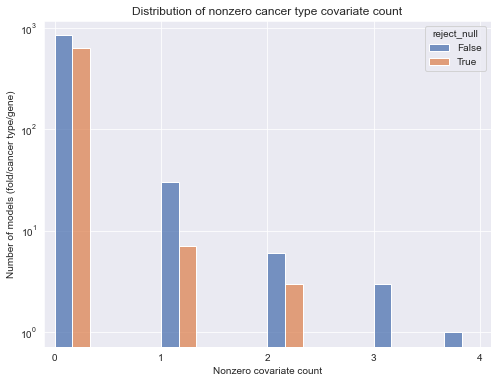

In [5]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=merge_df, x='nz_cov_count', hue='reject_null', log_scale=(False, True),
             kde=False, multiple='dodge')
plt.xticks(range(0, 5))
plt.xlim(-0.1, 4.1)
plt.title('Distribution of nonzero cancer type covariate count')
plt.xlabel('Nonzero covariate count')
plt.ylabel('Number of models (fold/cancer type/gene)')

In [6]:
identifier_mut_coefs = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        mut_cov = au.get_mutation_covariate(coefs)
        identifier_mut_coefs.append((identifier, fold_no, mut_cov))
        
mut_ids_df = pd.DataFrame(identifier_mut_coefs, columns=['identifier', 'fold', 'mut_cov'])
mut_ids_df.head(n=10)

,identifier,fold,mut_cov
0,MAP3K1_BRCA,0,False
1,MAP3K1_BRCA,1,True
2,MAP3K1_BRCA,2,True
3,MAP3K1_BRCA,3,True
4,MAP3K1_COAD,0,False
5,MAP3K1_COAD,1,False
6,MAP3K1_COAD,2,False
7,MAP3K1_COAD,3,False
8,MAP3K1_UCEC,0,True
9,MAP3K1_UCEC,1,True


In [7]:
mut_merge_df = (
    mut_ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
              .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
mut_merge_df.head(n=8)

,identifier,fold,mut_cov,reject_null
0,MAP3K1_BRCA,0,False,True
1,MAP3K1_BRCA,1,True,True
2,MAP3K1_BRCA,2,True,True
3,MAP3K1_BRCA,3,True,True
4,MAP3K1_COAD,0,False,False
5,MAP3K1_COAD,1,False,False
6,MAP3K1_COAD,2,False,False
7,MAP3K1_COAD,3,False,False


/home/jake/anaconda3/envs/pancancer-evaluation/lib/python3.6/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


([<matplotlib.axis.XTick at 0x7f10593e6080>,
 [Text(0, 0, ''), Text(0, 0, '')])

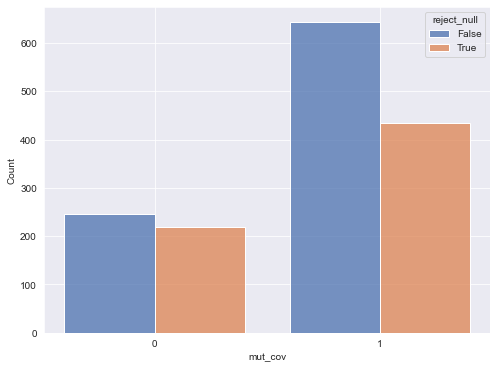

In [13]:
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=mut_merge_df, x='mut_cov', hue='reject_null',
             kde=False, discrete=True, multiple='dodge', shrink=.8)
plt.xticks((0, 1))

In [9]:
# get top n genes in terms of MAD
# note the actual feature selection may be different, since it does this selection
# independently for each training set (subset of all data)
rnaseq_df = du.load_expression_data(verbose=True)
mad_genes_df = (
    rnaseq_df.mad(axis=0)
             .sort_values(ascending=False)
             .reset_index()
)
mad_genes_df.columns = ['gene_id', 'mean_absolute_deviation']
mad_genes = mad_genes_df.gene_id.astype(str).values
print(mad_genes[:5])
mad_genes_df.head()

Loading gene expression data...


['213' '7038' '1277' '2335' '3852']


,gene_id,mean_absolute_deviation
0,213,154357.230103
1,7038,77954.882427
2,1277,74338.643636
3,2335,66635.420552
4,3852,62003.720145


In [10]:
# how many of nonzero coefficients are in top n MAD genes?
n_mad_genes = 4000

identifier_mad_coefs = []
for identifier, coefs_list in au.generate_nonzero_coefficients(pancancer_dir):
    for fold_no, coefs in enumerate(coefs_list):
        mad_proportion = au.get_mad_proportion(coefs, mad_genes[:n_mad_genes])
        identifier_mad_coefs.append((identifier, fold_no, n_mad_genes, mad_proportion))
        
# TODO: do we need a way to generate list of all features?
mad_ids_df = pd.DataFrame(identifier_mad_coefs, columns=['identifier', 'fold', 'n_mad_genes', 'mad_proportion'])
mad_ids_df.head(n=10)

,identifier,fold,n_mad_genes,mad_proportion
0,MAP3K1_BRCA,0,4000,0.500000
1,MAP3K1_BRCA,1,4000,0.481663
2,MAP3K1_BRCA,2,4000,0.457077
3,MAP3K1_BRCA,3,4000,0.500000
4,MAP3K1_COAD,0,4000,0.427885
5,MAP3K1_COAD,1,4000,0.416667
6,MAP3K1_COAD,2,4000,0.433121
7,MAP3K1_COAD,3,4000,0.451411
8,MAP3K1_UCEC,0,4000,0.457286
9,MAP3K1_UCEC,1,4000,0.441860


<AxesSubplot:xlabel='mad_proportion', ylabel='Count'>

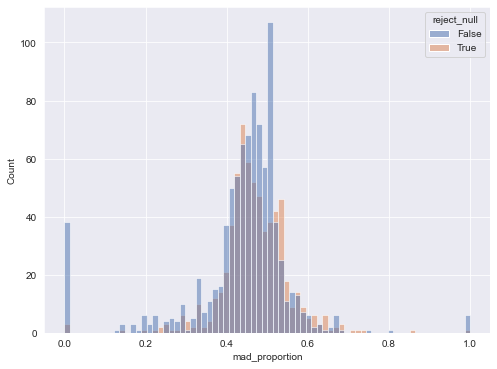

In [11]:
mad_merge_df = (
    mad_ids_df.merge(pancancer_comparison_df, left_on='identifier', right_on='identifier')
              .drop(columns=['delta_mean', 'p_value', 'corr_pval', 'nlog10_p'])
)
sns.set({'figure.figsize': (8, 6)})
sns.histplot(data=mad_merge_df, x='mad_proportion', hue='reject_null', kde=False)